The objective of the code below is to use the RandAugment Technique for the purpose of auto augmentation to increase the size of the training data set artificially. The augmentation applied is shown to imporve the generalization of deep learning model in the vision tasks




```
**Task**: One shot learning
**Datasets** used: MNIST, Omniglot
**Model**: Siamese Network
**Objective function**: Pair loss function/contrastive loss function
```



Papers referred are:
1. Cubuk, Ekin D., et al. "Randaugment: Practical automated data augmentation with a reduced search space." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops. 2020.
https://arxiv.org/abs/1902.03477
2. Lake, Brenden M., Ruslan Salakhutdinov, and Joshua B. Tenenbaum. "The Omniglot challenge: a 3-year progress report." Current Opinion in Behavioral Sciences 29 (2019): 97-104.
https://arxiv.org/abs/1902.03477

The unofficial code for augmentation is present here:

https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py

***Note the network model and the dataset used in this notebook is not part of the github code repository***

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.utils.data 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from PIL import Image

# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **RandAugment and helper augmentation functions**

The content in the below cell has been taken from the unofficial code for RandAugmnet

In [ ]:
def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        # (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

# **From here: the rest of the code is written by me**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def plot_grid(images):
    #helper function to plot images as grids
    fig = plt.figure(figsize=(10,10))
    im = torchvision.utils.make_grid(images)
    plt.imshow(im.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

# **RandAugment N=4 and M =25**

In [ ]:
transformations = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5),0.5)])
transformations.transforms.insert(0, RandAugment(4, 25))

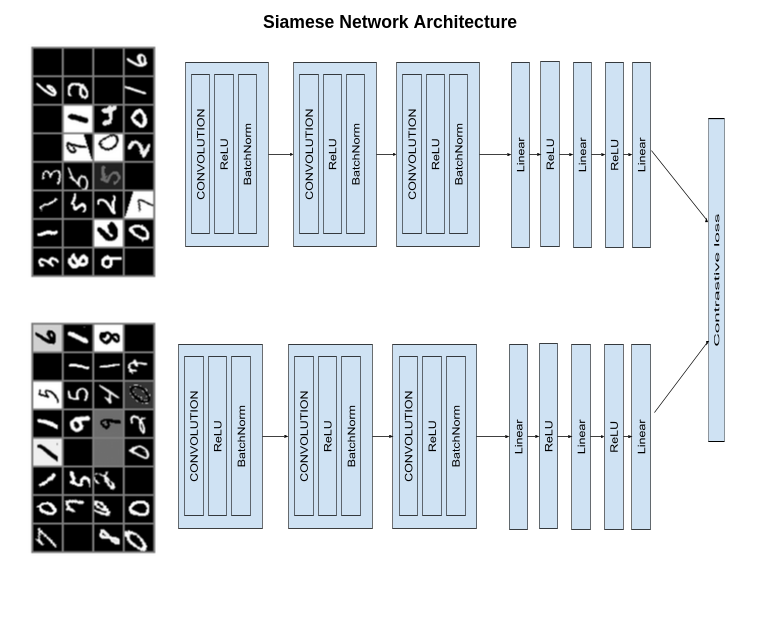

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self,img_size):

        super(SiameseNetwork, self).__init__()
        self.img_size = img_size
        self.sequential = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=1,out_channels=4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fullyconnected = nn.Sequential(
            nn.Linear(in_features=8*self.img_size*self.img_size, out_features=500),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=500, out_features=500),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=500, out_features=5))

    def forward_pass(self, x):
        # print(x.shape)
        output = self.sequential(x)
        # print(output.shape)
        output = output.view(output.size()[0], -1)
        # print(output.shape)
        output = self.fullyconnected(output)
        # print(output.shape)
        return output

    def forward(self, image1, image2):
        encoding1 = self.forward_pass(image1)
        encoding2 = self.forward_pass(image2)
        return encoding1, encoding2


import torch.nn.functional as F
class ContrastiveLoss(torch.nn.Module):
    """
    For positive pairs, the loss is given by
        L = d(f(x(i)), f(x(j)))
        For negative pairs,the loss is given by
        L = max(0, margin - d(f(x(i)), f(x(j))))
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        Contrastive_loss = (1-label)(euclidean_distance)^2 + (label) * (max(0,margin - euclidean_distance))^2
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, encoding1, encoding2, label):
        euclidean_distance = F.pairwise_distance(encoding1, encoding2, keepdim = True)
        loss = torch.mean(
                            (1-label) * torch.pow(euclidean_distance, 2) +
                              (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
                         )
        return loss

# **LOADING MNIST FROM PYTORCH DATASET**

I am using these downloaded folders to make a pair of inputs to the siamese network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([6, 4, 0, 6, 4, 0, 6, 1, 6, 9, 7, 7, 9, 0, 2, 5, 6, 5, 7, 3, 0, 1, 1, 3,
        5, 5, 1, 3, 0, 9, 6, 7])
Batch shape:  torch.Size([32, 1, 28, 28])


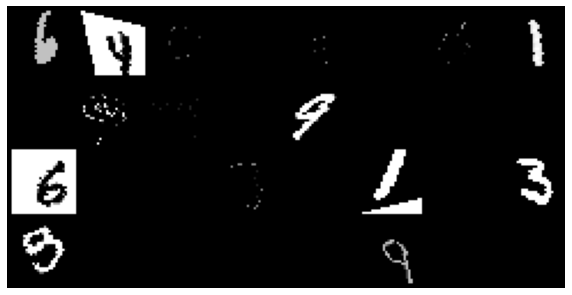

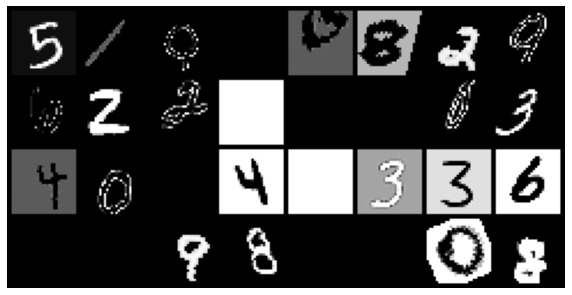

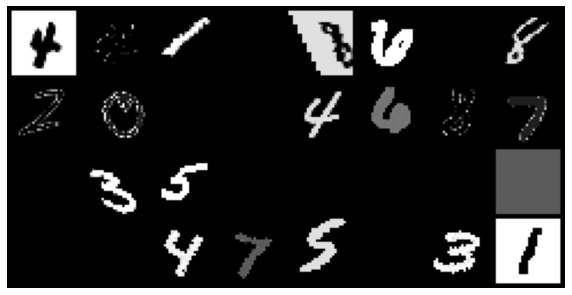

In [ ]:
batch_size = 32
mnist_data = torchvision.datasets.MNIST('/content/mnist', train=True, download=True, transform = transformations)
loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True, num_workers=1)


iter_ = iter(loader)
images, labels = iter_.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())

plot_grid(images)


iter_ = iter(loader)
images, labels = iter_.next()
plot_grid(images*0.5+0.5)

iter_ = iter(loader)
images, labels = iter_.next()
plot_grid(images*0.5+0.5)

# **SiamenseMNISTDataset Custom Class**

In [ ]:
class SiameseMNISTDataset(torch.utils.data.Dataset):

    def __init__(self,data, targets,transform):
        self.data = data
        self.targets = targets
        self.transform = transform
    def __getitem__(self,index):
        index = random.choice(range(len(self.data)))
        img0_tuple = self.data[index], int(self.targets[index])

        #randomly choose for a positive or a negative pair with 50%probability
        same_class = random.randint(0,1) 
        
        if same_class:
            while True:
                #look for a positvie pair in the same class
                index2 = random.choice(range(len(self.data)))
                img1_tuple = self.data[index2], int(self.targets[index2])
                #break only when positive pair is found
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            #different class =>negative pair
            while True:
                #look for negative pair 
                index2 = random.choice(range(len(self.data)))
                img1_tuple = self.data[index2], int(self.targets[index2])
                #break only when negative pair is found
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = img0_tuple[0]
        img1 = img1_tuple[0]
        img0 = Image.fromarray(img0.numpy(), mode='L')
        img1 = Image.fromarray(img1.numpy(), mode='L')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # print(torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)))
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.data)

# **Create Loader for the Paired images**

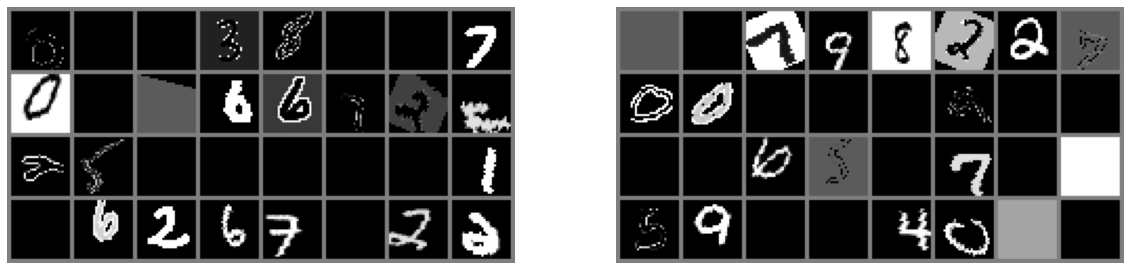

In [ ]:

siamese_mnist_traindataset = SiameseMNISTDataset(mnist_data.data,mnist_data.targets,transformations)

siamese_mnist_trainloader = torch.utils.data.DataLoader(siamese_mnist_traindataset, batch_size=batch_size, shuffle=True, num_workers=1)


iter_ = iter(siamese_mnist_trainloader)
image0,image1,l = iter_.next()

im0 = torchvision.utils.make_grid(image0)
im1 = torchvision.utils.make_grid(image1)
fig = plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.imshow((im0*0.5+0.5).permute(1, 2, 0))
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow((im1*0.5+0.5).permute(1, 2, 0))
plt.axis("off")
plt.show()


# **Instantiate model, optimizer and the loss funtion**

In [ ]:
siamese_mnist_net = SiameseNetwork(img_size=28).to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(siamese_mnist_net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

# **Training Siamese Network**

Epoch number 0            Batch 0/60000             Current loss 1.753943920135498
Epoch number 0            Batch 3200/60000             Current loss 1.1519083976745605
Epoch number 0            Batch 6400/60000             Current loss 1.0750741958618164
Epoch number 0            Batch 9600/60000             Current loss 1.0105286836624146
Epoch number 0            Batch 12800/60000             Current loss 1.428041934967041
Epoch number 0            Batch 16000/60000             Current loss 1.4720005989074707
Epoch number 0            Batch 19200/60000             Current loss 1.069340467453003
Epoch number 0            Batch 22400/60000             Current loss 1.234667181968689
Epoch number 0            Batch 25600/60000             Current loss 1.109452247619629
Epoch number 0            Batch 28800/60000             Current loss 0.8866159915924072
Epoch number 0            Batch 32000/60000             Current loss 1.2984492778778076
Epoch number 0            Batch 35200/60000 

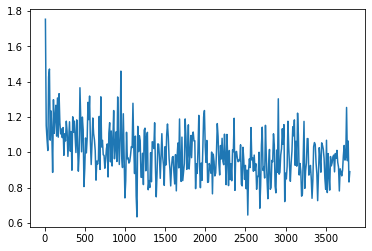

In [ ]:
for epoch in range(0,20):
    for i, data in enumerate(siamese_mnist_trainloader,0):
        img0, img1 , label = data
        
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        # print(img0.shape,img1.shape,label.shape)
        optimizer.zero_grad()
        output1,output2 = siamese_mnist_net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %100 == 0 :
            print("Epoch number {}\
            Batch {}/{} \
            Current loss {}".format(epoch,i*batch_size,len(siamese_mnist_trainloader)*batch_size,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

plt.plot(counter,loss_history)
plt.show()


Download the MNIST Test folder and make the pair

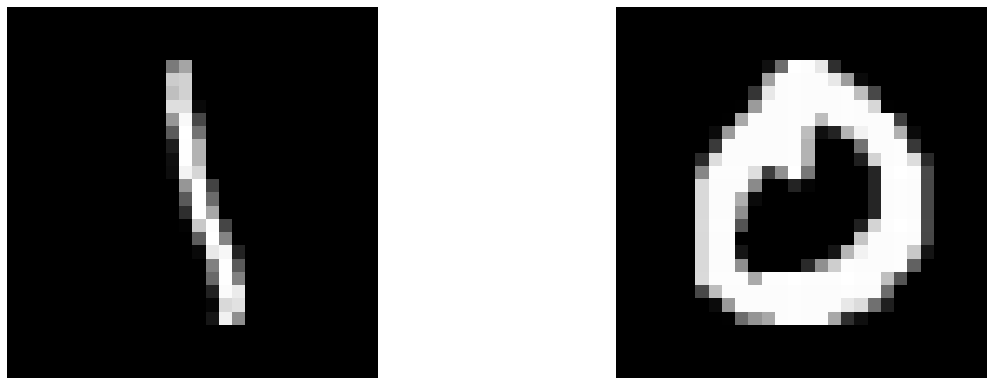

In [ ]:
mnist_test_data = torchvision.datasets.MNIST('/content/mnist', train=False, download=True, transform = torchvision.transforms.ToTensor())
siamese_mnist_testdataset = SiameseMNISTDataset(mnist_test_data.data,mnist_test_data.targets,torchvision.transforms.ToTensor())
siamese_mnist_testloader = torch.utils.data.DataLoader(siamese_mnist_testdataset, batch_size=1, shuffle= False, num_workers=1)


iter_ = iter(siamese_mnist_testloader)
image0,image1,l = iter_.next()

im0 = torchvision.utils.make_grid(image0)
im1 = torchvision.utils.make_grid(image1)
fig = plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.imshow((im0).permute(1, 2, 0))
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow((im1).permute(1, 2, 0))
plt.axis("off")
plt.show()

# **Testing on mnist**

Testing the siamese model

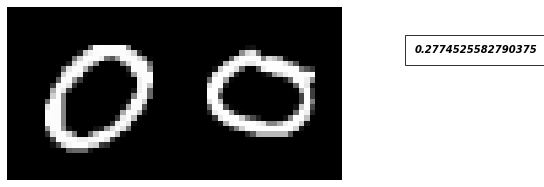

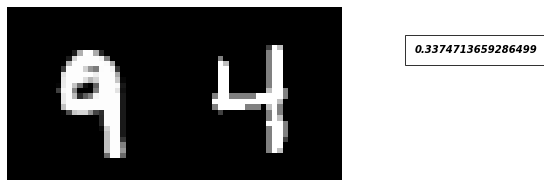

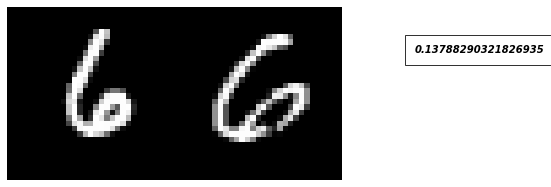

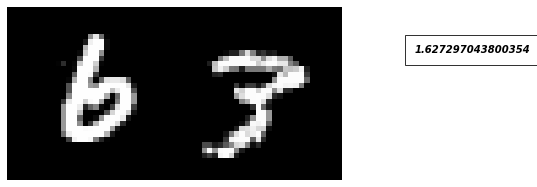

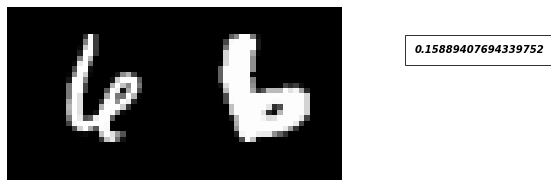

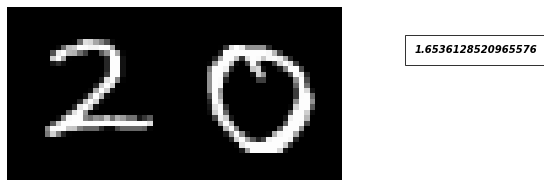

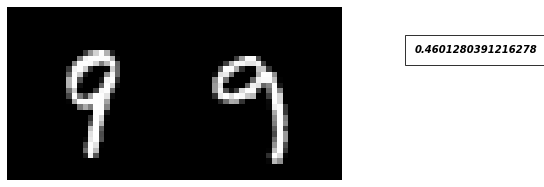

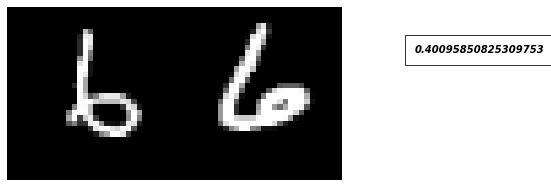

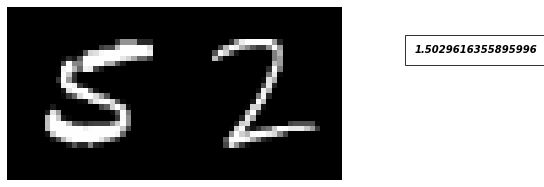

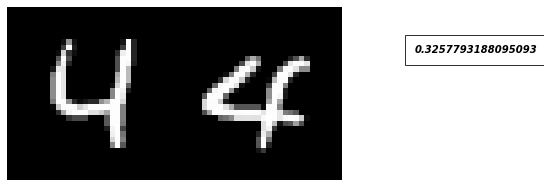

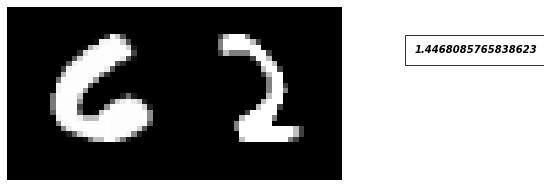

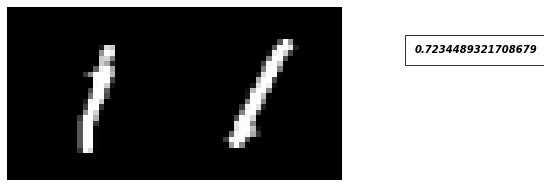

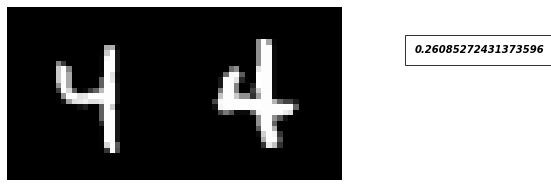

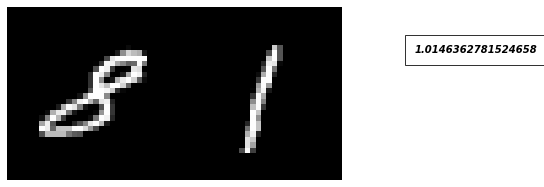

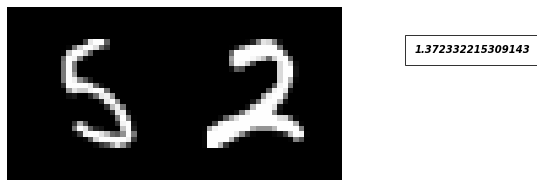

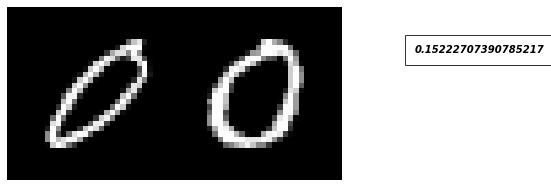

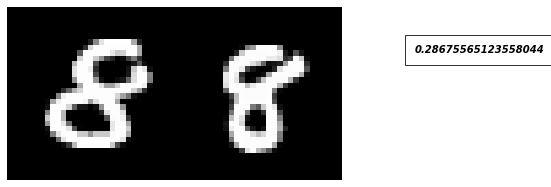

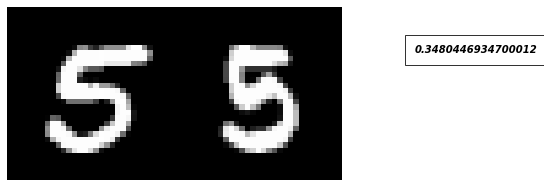

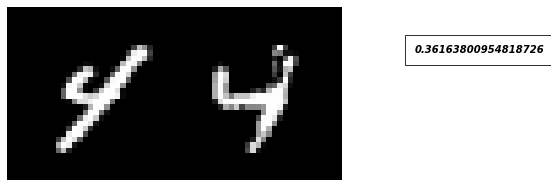

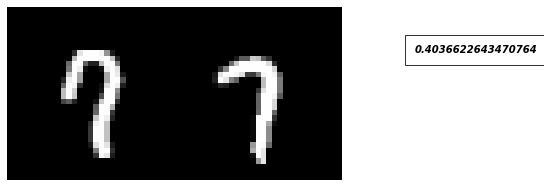

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(siamese_mnist_testloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = siamese_mnist_net(x0.to(device),x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2).detach().item()

    npimg = torchvision.utils.make_grid(concatenated).numpy()
    plt.axis("off")
    text = str(euclidean_distance)

    plt.text(75, 8, text, style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

    counter=counter+1
    if counter ==20:
        break

# **RandAugment Transformations for omniglot dataset**

In [ ]:
transformations = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5),0.5)])
transformations.transforms.insert(0, RandAugment(2, 30))

# **Load the omniglot data from pytorch dataset**

Extracting /content/omnigdata/omniglot-py/images_background.zip to /content/omnigdata/omniglot-py


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


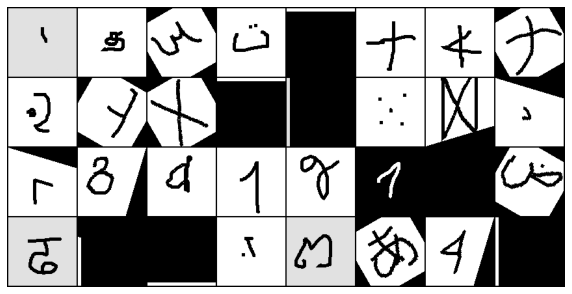

19280

In [ ]:
batch_size=32
omniglot_data = torchvision.datasets.Omniglot('/content/omnigdata', background=True, download=True, transform = transformations)
omiloader = torch.utils.data.DataLoader(omniglot_data, batch_size=batch_size, shuffle=True, num_workers=1)

iter_ = iter(omiloader)
images, labels = iter_.next()

plot_grid(images)

len(omniglot_data)

# **SiameseOMNIDataset Custom Class**


The custom class creates positive pair and a negative pair

In [ ]:
class SiameseOMNIDataset(torch.utils.data.Dataset):

    def __init__(self,flat_character_images,characters,target_folder,transform):
        #these flat_character images are from the ominglot data
        self._flat_character_images = flat_character_images
        self._characters = characters
        self.target_folder = target_folder
        self.transform = transform
    def __getitem__(self,index):
        #ignore the index set as an argument to getitem
        #make a random choice for the image
        index = random.choice(range(len(self._flat_character_images)))
        img0_tuple = self._flat_character_images[index]

        #toss a coin to either get a positive pair or negative pair with 50% probability
        same_class = random.randint(0,1) 
        if same_class:
            while True:
                
                #randomly sample index until another positive pair appears
                index2 = random.choice(range(len(self._flat_character_images)))
                img1_tuple = self._flat_character_images[index2]
                #break when the label of the selected image and its pair are the same
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                 #randomly sample index until another negative pair appears
                index2 = random.choice(range(len(self._flat_character_images)))
                img1_tuple = self._flat_character_images[index2]

                if img0_tuple[1] !=img1_tuple[1]:
                    break
        img0_path = os.path.join(self.target_folder, self._characters[img0_tuple[1]], img0_tuple[0])
        img0 = Image.open(img0_path, mode='r').convert('L')

        img1_path = os.path.join(self.target_folder, self._characters[img1_tuple[1]], img1_tuple[0])
        img1 = Image.open(img1_path, mode='r').convert('L')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    def __len__(self):
        return len(self._flat_character_images)


# **Create loader for the Paired Images**

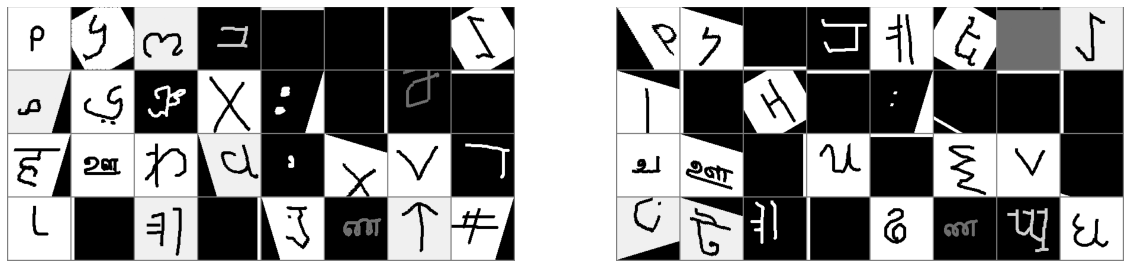

In [ ]:
siamese_omni_traindataset = SiameseOMNIDataset(omniglot_data._flat_character_images,omniglot_data._characters,omniglot_data.target_folder,transformations)

siamese_omni_trainloader = torch.utils.data.DataLoader(siamese_omni_traindataset, batch_size=batch_size, shuffle=True, num_workers=1)


#plot the paired images
iter_ = iter(siamese_omni_trainloader)
image0,image1,l = iter_.next()

im0 = torchvision.utils.make_grid(image0)
im1 = torchvision.utils.make_grid(image1)
fig = plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.imshow((im0*0.5+0.5).permute(1, 2, 0))
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow((im1*0.5+0.5).permute(1, 2, 0))
plt.axis("off")
plt.show()


# **Instatiate model, optimizer and the loss function**

In [ ]:
siamese_omni_net = SiameseNetwork(img_size=105).to(device)
criterion = ContrastiveLoss(margin=3)
optimizer = torch.optim.Adam(siamese_omni_net.parameters(),lr = 0.0005 )



In [ ]:
siamese_omni_net

# **Training the siamese model**

Epoch number 0            Batch 0/19296             Current loss 2.8499271869659424
Epoch number 0            Batch 3200/19296             Current loss 2.8020331859588623
Epoch number 0            Batch 6400/19296             Current loss 2.5158467292785645
Epoch number 0            Batch 9600/19296             Current loss 2.551884412765503
Epoch number 0            Batch 12800/19296             Current loss 2.090620517730713
Epoch number 0            Batch 16000/19296             Current loss 2.376957416534424
Epoch number 0            Batch 19200/19296             Current loss 2.8091161251068115
Epoch number 1            Batch 0/19296             Current loss 2.4635915756225586
Epoch number 1            Batch 3200/19296             Current loss 1.9377986192703247
Epoch number 1            Batch 6400/19296             Current loss 2.6605491638183594
Epoch number 1            Batch 9600/19296             Current loss 2.151285171508789
Epoch number 1            Batch 12800/19296       

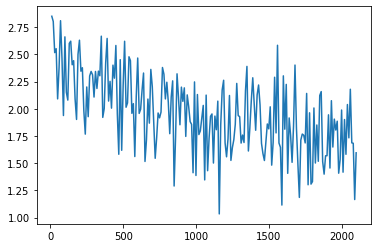

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
for epoch in range(0,30):
    for i, data in enumerate(siamese_omni_trainloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        # print(img0.shape,img1.shape,label.shape)
        optimizer.zero_grad()
        output1,output2 = siamese_omni_net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %100 == 0 :
            print("Epoch number {}\
            Batch {}/{} \
            Current loss {}".format(epoch,i*batch_size,len(siamese_omni_trainloader)*batch_size,loss_contrastive.item()))
            iter +=10
            counter.append(iter)
            loss_history.append(loss_contrastive.item())

plt.plot(counter,loss_history)
plt.show()

# **Download the Omniglot test folder and make the pair**

Files already downloaded and verified


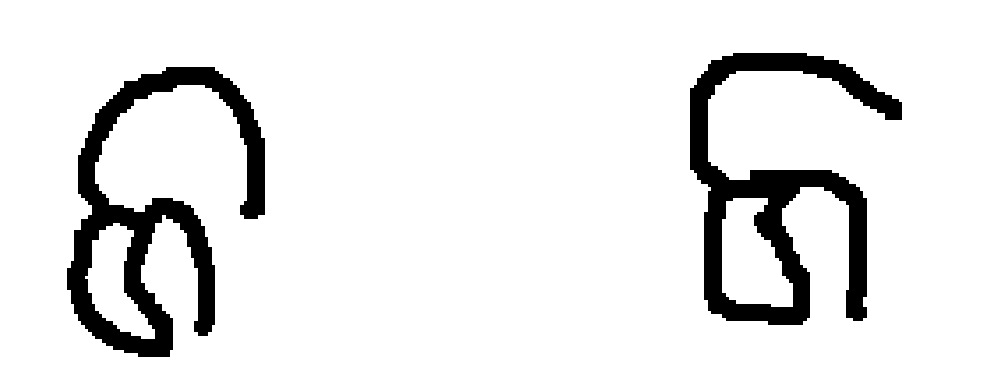

In [ ]:
omni_test_data = torchvision.datasets.Omniglot('/content/omnigdata', background=False, download=True, transform = torchvision.transforms.ToTensor())
siamese_omni_testdataset = SiameseOMNIDataset(omni_test_data._flat_character_images,omni_test_data._characters,omni_test_data.target_folder,torchvision.transforms.ToTensor())
siamese_omni_testloader = torch.utils.data.DataLoader(siamese_omni_testdataset, batch_size=1, shuffle=False, num_workers=1)


iter_ = iter(siamese_omni_testloader)
image0,image1,l = iter_.next()

im0 = torchvision.utils.make_grid(image0)
im1 = torchvision.utils.make_grid(image1)
fig = plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.imshow((im0).permute(1, 2, 0))
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow((im1).permute(1, 2, 0))
plt.axis("off")
plt.show()

# **Testing the siamese model on omniglot**

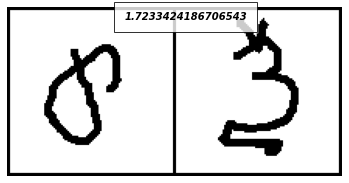

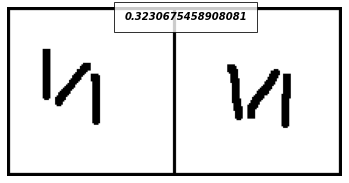

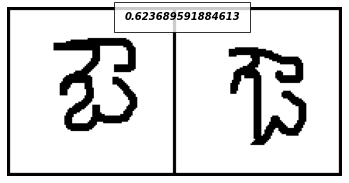

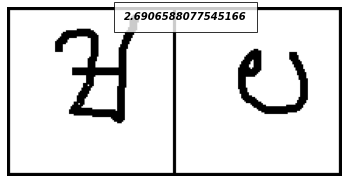

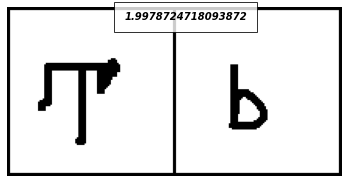

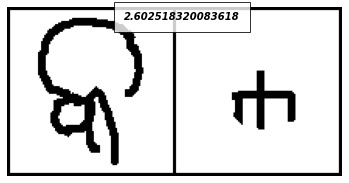

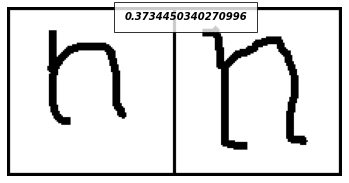

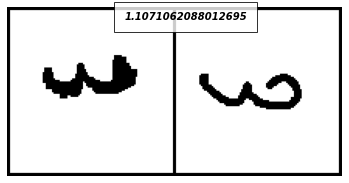

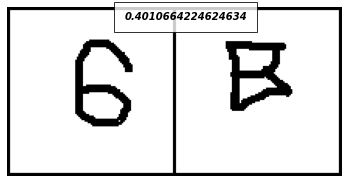

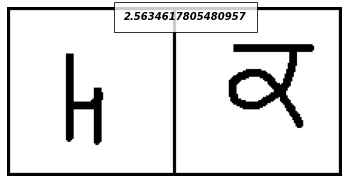

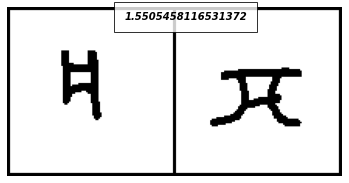

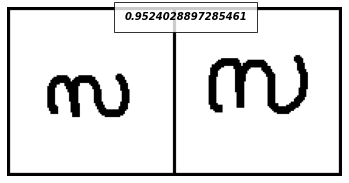

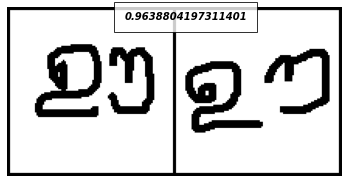

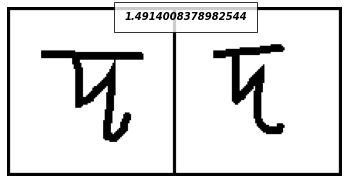

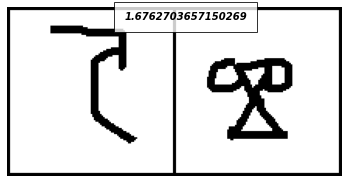

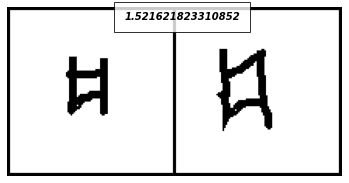

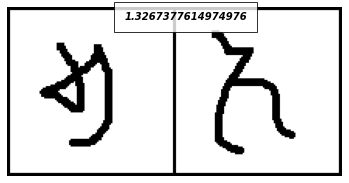

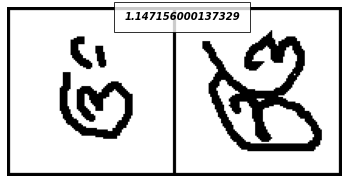

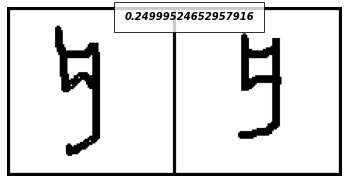

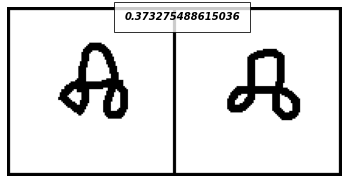

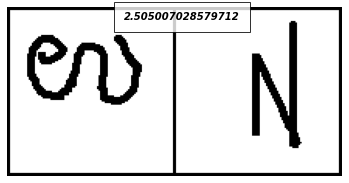

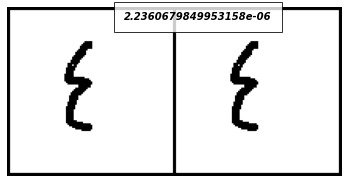

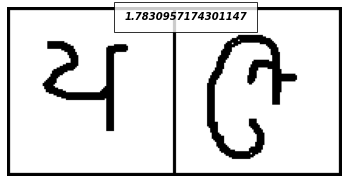

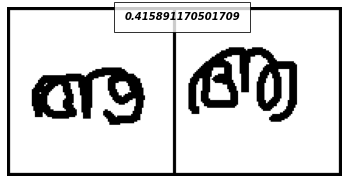

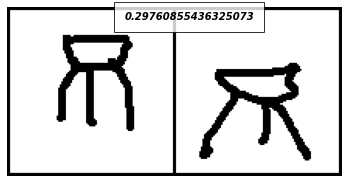

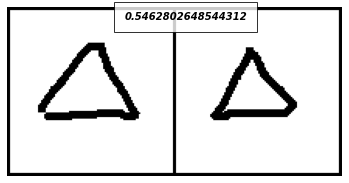

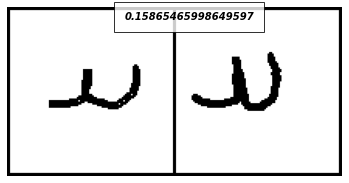

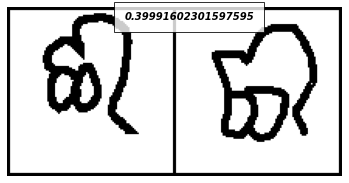

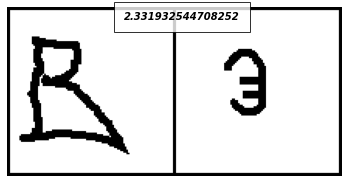

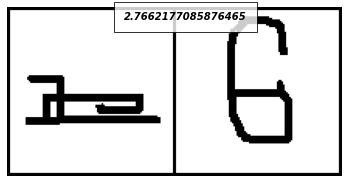

In [ ]:

#Find the dissimlarities in the test pairs
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
siamese_omni_net.eval()
for _, data in enumerate(siamese_omni_testloader): 
    img0, img1 , label = data
    concatenated = torch.cat((img0,img1),0)
    output1,output2 = siamese_omni_net(img0.to(device),img1.to(device))
    # print(euclidean_distance)
    euclidean_distance = F.pairwise_distance(output1, output2).detach().item()
    npimg = torchvision.utils.make_grid(concatenated).numpy()
    plt.axis("off")
    text = str(euclidean_distance)
    plt.text(75, 8, text, style='italic',fontweight='bold',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    counter=counter+1
    if counter ==30:
        break

**Conclusion**

```
The Omniglot network is wider and deeper compared to the network used for MNIST. 
As the network got wider, the magnitude of distortion needed to be increased. 

The MNIST dataset is larger compared to the omniglot dataset. 
When the size of the dataset increases, the magnitude of transformation has to 
be increased. Therefore, the strength of the augmentation strongly depends on 
model size and on the size of the data set size.
The search space for the hyperparameter in RA is reduced to an extent
that it can be directly applied to the target task instead of a proxy task.
```



# **Reproducing the results of the paper using a pretrained model**

# **RandAugment N=3 and M =7**

As used by the paper


Model: WideResnet 28 * 10

Dataset: Street view house numbers

Augmentation: randaugment

randaugment:

  N: 3

  M: 7    

Batch: 256

epoch: 5

Learning rate: 0.005

Optimizer: Stochastic gradient descent with nestrov and decay =0.001


In [ ]:
transformations = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5),0.5)])
transformations.transforms.insert(0, RandAugment(3, 7))
from torchvision.datasets import SVHN
svhn_data = SVHN(root='/content/svhn', download=True, transform=transformations)
svhn_loader = torch.utils.data.DataLoader(svhn_data, batch_size=32, shuffle=False, num_workers=1)

Using downloaded and verified file: /content/svhn/train_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([1, 9, 2, 3, 2, 5, 9, 3, 3, 1, 3, 3, 2, 8, 7, 4, 4, 1, 2, 8, 1, 6, 2, 3,
        6, 3, 4, 2, 5, 8, 1, 6])
Batch shape:  torch.Size([32, 3, 32, 32])


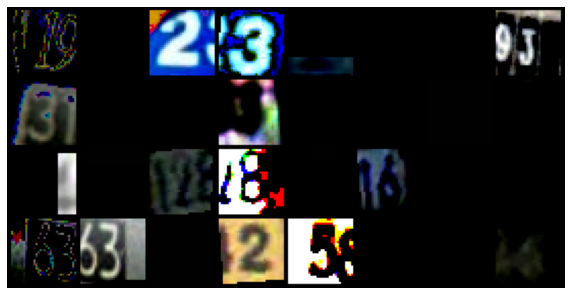

In [ ]:
iter_ = iter(svhn_loader)
images, labels = iter_.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())

plot_grid(images)

In [ ]:
! pip install git+https://github.com/Srigowri/pytorch-randaugment 

  Cloning https://github.com/Srigowri/pytorch-randaugment to /tmp/pip-req-build-rghpjw4m
  Running command git clone -q https://github.com/Srigowri/pytorch-randaugment /tmp/pip-req-build-rghpjw4m
  Created wheel for RandAugment: filename=RandAugment-0.1-cp36-none-any.whl size=24223 sha256=8dd75f085d135827f6eab100ff2534321eac36846b6cc880619684f404695e2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1lvmjd6/wheels/02/ad/79/e5514e4148999b9f7394676f62bc8e174fbdef912fc153671a
Successfully built RandAugment


In [ ]:
! git clone https://github.com/Srigowri/pytorch-randaugment.git

Cloning into 'pytorch-randaugment'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 107 (delta 57), reused 71 (delta 31), pack-reused 0
Receiving objects: 100% (107/107), 31.70 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
! ls 
% cd pytorch-randaugment/
! ls

! pip install -r requirements.txt --quiet

pytorch-randaugment  sample_data
/content/pytorch-randaugment
confs  LICENSE	RandAugment  README.md	requirements.txt  setup.py
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 317kB 15.3MB/s 
     |████████████████████████████████| 48.5MB 62kB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 3.2MB 49.0MB/s 
     |████████████████████████████████| 204kB 64.5MB/s 
     |████████████████████████████████| 133kB 48.0MB/s 
     |████████████████████████████████| 81kB 13.5MB/s 
     |████████████████████████████████| 1.3MB 50.8MB/s 
     |████████████████████████████████| 71kB 12.2MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
     |████████████████████████████████| 143kB 59.9MB/s 
     |████████████████████████████████| 296kB 60.9MB/s 
     |████████████████████████████████| 61

In [ ]:
! python RandAugment/train.py -c confs/wresnet28x10_svhn_b256.yaml --save svhn_wres28x10.pth

Streaming output truncated to the last 5000 lines.

[train 0005/0005]:  69% 1635/2360 [19:44<08:44,  1.38it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1636/2360 [19:44<08:41,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1636/2360 [19:45<08:41,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1637/2360 [19:45<08:41,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1637/2360 [19:45<08:41,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1638/2360 [19:45<08:39,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1638/2360 [19:46<08:39,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1639/2360 [19:46<08:39,  1.39it/s, loss=0.933, top1=0.667, top5=0.899, lr=0.00743]


[train 0005/0005]:  69% 1639/2360 [19:47<08:39,  1.39it/s, loss=0.933, top1=